# Build a simple classifier for the MNIST dataset

To build our model we need to do a few steps:
- Download the MNIST dataset with consist of labeled handwritten images (28x28 px).
- Construct 10 logistic regression models for the one vs rest classification.
- Train our model and then test and validate how well we did.

#  0. Load our packages

In [1]:
import numpy as np
import pandas as pd
import keras

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

# 1. Load the data
The MNIST database is available as a dataset in Keras. Note: the data comes on a single channel, as opposed to the 3-channel presentation in the lectures. This will lead to having slightly fewer parameters in the model.

In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical

img_rows, img_cols = 28, 28
num_classes = 10

(x_temp, y_temp), (x_test, y_test) = mnist.load_data()

print('We have %2d training (this includes validation data) pictures and %2d test pictures.' % (x_temp.shape[0],x_test.shape[0]))
print('Each picture is of size (%2d,%2d)' % (x_temp.shape[1], x_temp.shape[2]))

We have 60000 training (this includes validation data) pictures and 10000 test pictures.
Each picture is of size (28,28)


In [3]:
print("######### Train ##########")
print(f"x_train shape: {x_temp.shape}")
print(f"y_train shape: {y_temp.shape}")
print("######### Test ##########")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

######### Train ##########
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
######### Test ##########
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


# 2. Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by more or less the same number of samples.

#### Display some images

In [4]:
def display_train_image(position):
    plt.figure(figsize=(1,1))
    plt.title(f"Example {position}, label: {y_temp[position]}")
    #plt.title('Example %d. Label: %d' % (position, y_train[position]))
    plt.imshow(x_temp[position], cmap=plt.cm.gray_r)
    plt.show()
    plt.close()

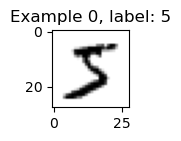

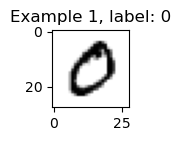

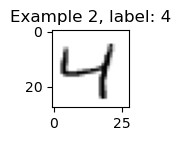

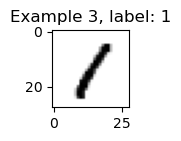

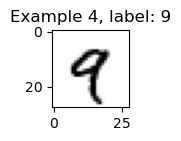

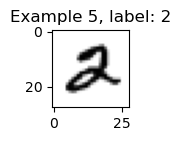

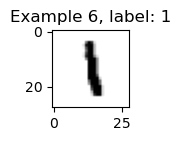

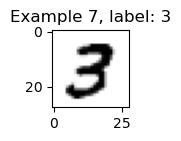

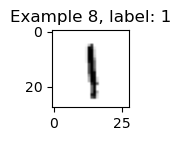

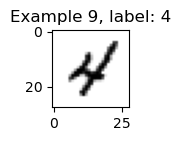

In [5]:
for i in range(10):
    display_train_image(i)

#### Is the training data balanced?

In [6]:
y_temp_count = np.unique(y_temp, return_counts=True)
dataframe_y_temp = pd.DataFrame({'Label':y_temp_count[0], 'Count':y_temp_count[1]})
dataframe_y_temp

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [7]:
y_temp_count = np.unique(y_temp, return_counts=True)
y_temp_count

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [8]:
df_y_temp = pd.DataFrame({"Label": y_temp_count[0],
                           "Count": y_temp_count[1],
                           "%": np.round((y_temp_count[1] / y_temp.size) * 100, 3)})
df_y_temp

,Label,Count,%
0,0,5923,9.872
1,1,6742,11.237
2,2,5958,9.930
3,3,6131,10.218
4,4,5842,9.737
5,5,5421,9.035
6,6,5918,9.863
7,7,6265,10.442
8,8,5851,9.752
9,9,5949,9.915


We conclude that the data is balanced between the different labels. So we can continue with the modeling without extra manipulation of the dataset.

# 3. Data preprocessing

In [9]:
# Reset the seed of the random number generator, for reproducibility purposes
np.random.seed(2023)

In [10]:
# Split the temporal dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_temp, 
                                                  y_temp, 
                                                  test_size=0.2, 
                                                  random_state=2023, 
                                                  stratify=y_temp)

- <p style="margin-bottom: 20px;">The stratify parameter in the train_test_split function from the scikit-learn library ensures that the split data has the same distribution of classes as the original dataset.</p>

- <p style="margin-bottom: 20px;"><b>Without</b> specifying $\, \text{stratify}=\text{y_temp} \,$: when you split your data, the distribution of classes in the training and validation sets might be uneven, especially if your dataset is imbalanced (i.e., some classes have significantly more samples than others). This could lead to biased models or models that do not generalize well.</p>

- <p style="margin-bottom: 20px;"><b>With $\, \text{stratify}=\text{y_temp} \,$</b>: <i>the train_test_split</i> function ensures that the training and validation sets have the same proportion of each class as the original dataset y_train. This is important when you have a classification problem and want to maintain the class distribution in both your training and validation sets.</p>

- The stratify parameter in the train_test_split function from the scikit-learn library ensures that the split data has the same distribution of classes as the original dataset.



- Without stratify: 
    - when you split your data, the distribution of classes in the training and validation sets might be uneven, especially if your dataset is imbalanced (i.e., some classes have significantly more samples than others). This could lead to biased models or models that do not generalize well.

- With stratify=y_train: The train_test_split function ensures that the training and validation sets have the same proportion of each class as the original dataset y_train. This is important when you have a classification problem and want to maintain the class distribution in both your training and validation sets.

In [11]:
# Check the results of the data split (Train ==> (Train | Validation))
print("########## Temporal ##########")
print(df_y_temp.to_string(index=False))

print()

print("########## Training ##########")
print(f"Number of training images: {x_train.shape[0]}")
y_train_count = np.unique(y_train, return_counts=True)
df_y_train = pd.DataFrame({"Label": y_train_count[0],
                           "Count": y_train_count[1],
                           "%": np.round((y_train_count[1] / np.sum(y_train_count[1])) * 100, 3)})
print(df_y_train.to_string(index=False))

print()

print("########## Validation ##########")
print(f"Number of validation images: {x_val.shape[0]}")
y_val_count = np.unique(y_val, return_counts=True)
df_y_val = pd.DataFrame({"Label": y_val_count[0],
                         "Count": y_val_count[1],
                         "%": np.round((y_val_count[1] / np.sum(y_val_count[1])) * 100, 3)})
print(df_y_val.to_string(index=False))

########## Temporal ##########
 Label  Count      %
     0   5923  9.872
     1   6742 11.237
     2   5958  9.930
     3   6131 10.218
     4   5842  9.737
     5   5421  9.035
     6   5918  9.863
     7   6265 10.442
     8   5851  9.752
     9   5949  9.915

########## Training ##########
Number of training images: 48000
 Label  Count      %
     0   4738  9.871
     1   5394 11.238
     2   4766  9.929
     3   4905 10.219
     4   4674  9.738
     5   4337  9.035
     6   4734  9.862
     7   5012 10.442
     8   4681  9.752
     9   4759  9.915

########## Validation ##########
Number of validation images: 12000
 Label  Count      %
     0   1185  9.875
     1   1348 11.233
     2   1192  9.933
     3   1226 10.217
     4   1168  9.733
     5   1084  9.033
     6   1184  9.867
     7   1253 10.442
     8   1170  9.750
     9   1190  9.917


- As can be seen, when specifying $\, \text{stratify} = \text{y_temp}, \,$ the splitted data has the same distribution of classes as the original dataset (original here is the argument to the *stratify* parameter).

- <p style="margin-bottom: 20px;">The stratify parameter in the train_test_split function from the scikit-learn library ensures that the split data has the same distribution of classes as the original dataset.</p>

#### Scale the training data

In [12]:
print(f"The training data has values in the interval: [{np.min(x_train)}, {np.max(x_train)}]")

The training data has values in the interval: [0, 255]


In [13]:
# Scale the training data into interval [0, 1]
x_train = x_train / np.max(x_train)

In [14]:
print(F"The training data has values in the interval: [{np.min(x_train)}, {np.max(x_train)}]")

The training data has values in the interval: [0.0, 1.0]


In [15]:
# Reshape the data so that each 28x28 picture is transformed into an array of shape (28*28,)
x_train = x_train.reshape(x_train.shape[0], -1)
print(f"Shape of the training data after reshape: {x_train.shape}")

Shape of the training data after reshape: (48000, 784)


# 4. Machine learning with logistic regression

#### Train a logistic regression model using a "one vs rest" model
This trains internally 10 different binary classification models. For each datapoint, 10 predictions are generated, the one with the highest probability is selected as the prediction of the logistic regression model.

In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='ovr', max_iter=100, random_state=10)
clf = clf.fit(x_train, y_train)

/Users/herrakaava/anaconda3/envs/fml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Check the score on the training data

print("Score on training data: %.4f" % clf.score(x_train, y_train))

Score on training data: 0.9286


In [18]:
# Scale and reshape the validation and test data as well
x_val = x_val / 255
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test / 255
x_test = x_test.reshape(x_test.shape[0], -1)

#### Check on the validation data 


### Q1: What is the score of the one vs. rest on the validation data (4 decimals only)?

In [19]:
# Your code here
print(f"Score on the validation data: {clf.score(x_val, y_val):.4f}")

Score on the validation data: 0.9156


#### Check other metrics of the model

Accuracy on the validation data: 0.9155833333333333
F1 Score on the validation data: 0.9158598266687824
The confusion matrix on the validation data:


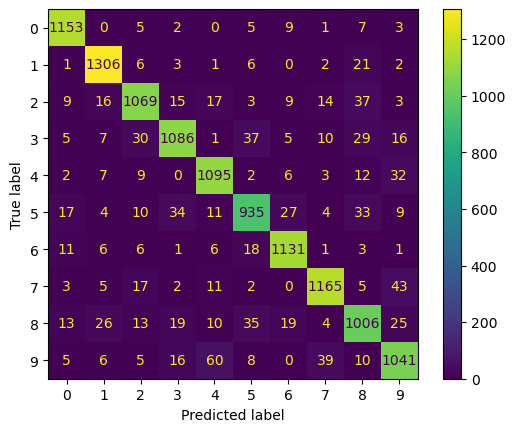

In [20]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

y_pred_val = clf.predict(x_val)
accuracy_val = accuracy_score(y_pred_val, y_val)
f1_val = f1_score(y_pred_val, y_val, average="weighted")

print("Accuracy on the validation data:", accuracy_val)
print("F1 Score on the validation data:", f1_val)

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cm = confusion_matrix(y_val, y_pred_val, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
print("The confusion matrix on the validation data:")
disp.plot()
plt.show();

#### We noticed that the learning was stopped before it converged. Let's increase the number of iterations in the learning algorithm from 100 to 1000. 

### Q2: What is the score of the better trained one vs. rest model on the validation data (4 decimals only)?

In [21]:
clf_2 = LogisticRegression(multi_class="ovr", max_iter=1000, random_state=10)
clf_2 = clf_2.fit(x_train, y_train)

In [22]:
print(f"clf_2 score on the validation data: {clf_2.score(x_val, y_val):.4f}")

clf_2 score on the validation data: 0.9156


#### Train now a logistic regression model for the entire 10-class classification problem (using a softmax function to select the prediction on a datapoint. 

### Q3: What is the score of the multi-class model on the training and on the validation data (4 decimals only)?

In [23]:
clf_softmax = LogisticRegression(multi_class="multinomial", max_iter=100, random_state=10)
clf_softmax.fit(x_train, y_train)

/Users/herrakaava/anaconda3/envs/fml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=10)

In [24]:
print(f"clf_softmax score on the validation data: {clf_softmax.score(x_val, y_val):.4f}")

clf_softmax score on the validation data: 0.9203


#### We noticed that the learning was stopped before it converged. Let's increase the number of iterations in the learning algorithm from 100 to 1000. 

### Q4: What is the score of the better trained multi-class model on the training and on the validation data (4 decimals only)?

In [25]:
clf_softmax_2 = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=10)
clf_softmax_2.fit(x_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=10)

In [26]:
print(f"clf_softmax_2 score on the validation data: {clf_softmax_2.score(x_val, y_val):.4f}")

clf_softmax_2 score on the validation data: 0.9195


#### We now can select the final model. Take the one with the highest score on the validation data. 

### Q5: Which model did you select (one vs. rest or multi-class)?

#### Check the final model on the test dataset

### Q6: What is the score of the final model on the test data (4 decimals only)?

In [27]:
# Scale the test data
x_test = x_test.reshape(x_test.shape[0], -1)
x_test.shape

(10000, 784)

In [28]:
print(f"clf_softmax_2 score on the test data: {clf_softmax_2.score(x_test, y_test):.4f}")

clf_softmax_2 score on the test data: 0.9235
